# Oddstradamus
### Good odds and where to find them

### Modelling (Away)

In this notebook, the 3 remaining data frames are used to classify matches between away win and double chance draw or home win. The procedure is the same as in the [previous notebook](https://github.com/mue94/oddstradamus/blob/main/05_Model_Home.ipynb). 
Therefore, here is an overview of the machine learning algorithms used within this notebook. Note also the PCA as point number 3 for each data frame.

| 1 Full-Dataframe | 2 50%-Dataframe | 3 Favorite-Dataframe |
| - | - | - |
| 1 Dummy Classifier | 1 Dummy Classifier | 1 Dummy Classifier |
| 2 Logistic Regression | 2 Logistic Regression | 2 Logistic Regression |
| 4 Logistic Regression (PCA) | 4 Logistic Regression (PCA) | 4 Logistic Regression (PCA) |
| 5 Support Vector Machine (PCA) | 5 Support Vector Machine (PCA) | 5 Support Vector Machine (PCA) |
| 6 Random Forest (PCA) | 6 Random Forest (PCA) | 6 Random Forest (PCA) |
| 7 Extra Trees (PCA) | 7 Extra Trees (PCA) | 7 Extra Trees (PCA) |
| 8 KNN (PCA) | 8 KNN (PCA) | 8 KNN (PCA) |
| 9 AdaBoost (PCA) | 9 AdaBoost (PCA) | 9 AdaBoost (PCA) |
| 10 XGBoost (PCA) | 10 XGBoost (PCA) | 10 XGBoost (PCA) |

In [1]:
# import packages
# basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from joblib import dump, load

# scikit-learn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

#settings
warnings.filterwarnings('ignore')

### Metric

In [2]:
# defining the metrics

# risk-averse
def profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out, insert=1):
    profit = 0
    for i in range(len(actual)):
        if predicted[i] == '2':
            if actual[i] == predicted[i]:
                profit = profit + (((insert - (1/dc_odd[i])) * (1/avg_odd_fav[i])) * float(away_odd[i])) - ((insert - (1/dc_odd[i])) * (1/avg_odd_fav[i]))
            else:
                profit = profit - ((insert - (1/dc_odd[i])) * (1/avg_odd_fav[i]))
        if predicted[i] == '1X':
            if actual [i] == predicted[i]:
                profit = profit + (((insert - (1/away_odd[i])) * (1/avg_odd_out[i])) * float(dc_odd[i])) - ((insert - (1/away_odd[i])) * (1/avg_odd_out[i]))
            else:
                profit = profit - ((insert - (1/away_odd[i])) * (1/avg_odd_out[i]))
    
    print(round(profit,2),'units in',len(actual),'games')    
                
    return print(round(profit / len(actual)*100, 2),'% gain per game')

# risk-taking
def profit_metric_fav(actual, predicted, away_odd, dc_odd, insert=1):
    profit = 0
    for i in range(len(actual)):
        if predicted[i] == '2':
            if actual[i] == predicted[i]:
                profit = profit + ((insert - (1/dc_odd[i])) * float((away_odd[i])) - (insert - (1/dc_odd[i])))
            else:
                profit = profit - (insert - (1/dc_odd[i]))
        if predicted[i] == '1X':
            if actual [i] == predicted[i]:
                profit = profit + (insert - (1/away_odd[i])) * float((dc_odd[i])) - (insert - (1/away_odd[i]))
            else:
                profit = profit - (insert - (1/away_odd[i]))
    
    print(round(profit,2),'units in',len(actual),'games')    
                
    return print(round(profit / len(actual)*100, 2),'% gain per game')

## 1 Full Dataframe

In [3]:
# loading the dataframe
X_train_full = pd.read_csv('Data/model_away_csv/X_train_away_full.csv')
X_test_full = pd.read_csv('Data/model_away_csv/X_test_away_full.csv')
y_train_full = pd.read_csv('Data/model_away_csv/y_train_away_full.csv')
y_test_full = pd.read_csv('Data/model_away_csv/y_test_away_full.csv')
y_train_full = y_train_full['two_way_a_odd']
y_test_full = y_test_full['two_way_a_odd']

In [4]:
# assigning the variables of the profit metric
actual = y_test_full
away_odd = X_test_full.MaxAway
dc_odd = X_test_full.dc_home 
avg_odd_fav = X_test_full.awaywin_avg_odd
avg_odd_out = X_test_full.homewin_avg_odd

#### 1.1 Dummy Classifier

In [5]:
# create a Dummy-Model
model_dummy_full = DummyClassifier(strategy = 'most_frequent')

In [6]:
# fit the model
model_dummy_full.fit(X_train_full, y_train_full)

DummyClassifier(strategy='most_frequent')

In [7]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_dummy_full = model_dummy_full.predict(X_test_full)
predicted = y_pred_dummy_full.tolist()

In [8]:
# print the classification report
print(classification_report(y_test_full, y_pred_dummy_full))

              precision    recall  f1-score   support

          1X       0.70      1.00      0.82      8847
           2       0.00      0.00      0.00      3831

    accuracy                           0.70     12678
   macro avg       0.35      0.50      0.41     12678
weighted avg       0.49      0.70      0.57     12678



In [9]:
# print the result of the profit metric
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-212.84 units in 12678 games
-1.68 % gain per game


#### 1.2 Logistic Regression

In [10]:
# create a Logistic Regression Model / fit the model
logreg_full = LogisticRegression()
logreg_full.fit(X_train_full, y_train_full)

LogisticRegression()

In [11]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_full = logreg_full.predict(X_test_full)
predicted = y_pred_logreg_full.tolist()

In [12]:
# print the classification report
print(classification_report(y_test_full, y_pred_logreg_full))

              precision    recall  f1-score   support

          1X       0.71      0.97      0.82      8847
           2       0.58      0.11      0.18      3831

    accuracy                           0.71     12678
   macro avg       0.64      0.54      0.50     12678
weighted avg       0.67      0.71      0.63     12678



In [13]:
# print the result of the profit metric
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-203.1 units in 12678 games
-1.6 % gain per game


#### 1.3 Dimensionality Reduction

##### Data Scaling
PCA requires scaling/normalization of the data to work properly.

In [14]:
# assign the standard scaler
scaler = StandardScaler()

In [15]:
# scale train data with standard scaler
X_train_full_scaled = scaler.fit_transform(X_train_full)
df_full_scaled = pd.DataFrame(data=X_train_full_scaled,columns=X_train_full.columns)

##### Principal Componenent Analysis

In [16]:
# create a PCA object
pca_full = PCA(n_components=None)

In [17]:
# fit the PCA object
df_full_scaled_pca = pca_full.fit(df_full_scaled)

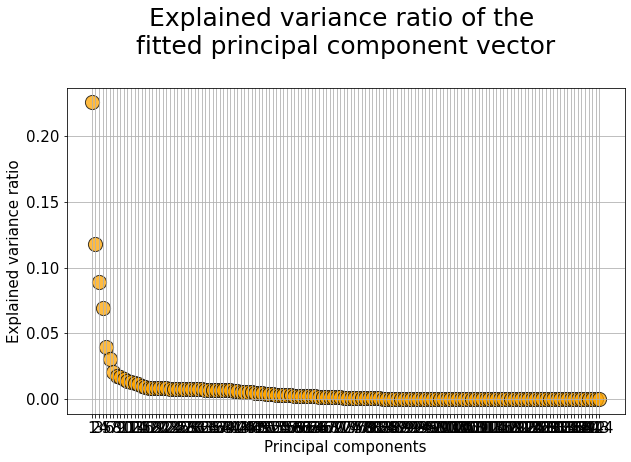

In [18]:
# plot the explained variance ratio for each principal component
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_full_scaled_pca.explained_variance_ratio_))],
            y=df_full_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_full_scaled_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [19]:
# transform the scaled data set using the fitted PCA object
X_train_full_scaled_trans = pca_full.transform(df_full_scaled)

In [20]:
# put it in a data frame
X_train_full_scaled_trans = pd.DataFrame(data=X_train_full_scaled_trans)

In [21]:
# assign the most meaningful variables
variables_full = [0,1,2,3,4,5,6]

#### 1.4 Logistic Regression (PCA)

In [22]:
# create a Logistic Regression Model / fit the model (PCA data)
logreg_full_pca = LogisticRegression()
logreg_full_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

LogisticRegression()

In [23]:
# scale test data with standard scaler / transform the scaled data set using the fitted PCA object
X_test_full_scaled = scaler.transform(X_test_full)
X_test_full_scaled_trans = pca_full.transform(X_test_full_scaled)

In [24]:
# put it in a data frame
X_test_full_scaled_trans = pd.DataFrame(data=X_test_full_scaled_trans)

In [25]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_full_pca = logreg_full_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])
predicted = y_pred_logreg_full_pca.tolist()

In [26]:
# print the classification report
print(classification_report(y_test_full, y_pred_logreg_full_pca))

              precision    recall  f1-score   support

          1X       0.73      0.96      0.83      8847
           2       0.64      0.16      0.26      3831

    accuracy                           0.72     12678
   macro avg       0.68      0.56      0.54     12678
weighted avg       0.70      0.72      0.65     12678



In [27]:
# print the result of the profit metric
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-206.44 units in 12678 games
-1.63 % gain per game


#### 1.5 Support Vector Machine (PCA)

In [28]:
# create a SVM-Model
model_full_svm_pca = SVC(kernel='linear', verbose = 1)

In [29]:
# fit the model
#model_full_svm_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

In [30]:
# save the fitted model
#dump(model_full_svm_pca, 'SVM_full_away.pickle')

In [31]:
# load the fitted model
model_full_svm_pca = load('SVM_full_away.pickle')

In [32]:
# predict the test data
y_pred_full_svm_pca = model_full_svm_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

In [33]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_svm_pca))

              precision    recall  f1-score   support

          1X       0.71      0.99      0.83      8847
           2       0.70      0.07      0.12      3831

    accuracy                           0.71     12678
   macro avg       0.70      0.53      0.47     12678
weighted avg       0.71      0.71      0.61     12678



In [34]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_svm_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-217.82 units in 12678 games
-1.72 % gain per game


#### 1.6 Random Forest (PCA)

In [35]:
# create a Random Forest-Model
model_full_rf_pca = RandomForestClassifier(n_estimators=120, 
                                           random_state=42, 
                                           max_features = 'sqrt',
                                           n_jobs=-1, verbose = 1)

In [36]:
# fit the model
model_full_rf_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.2s finished


RandomForestClassifier(max_features='sqrt', n_estimators=120, n_jobs=-1,
                       random_state=42, verbose=1)

In [37]:
# predict the test data
y_pred_full_rf_pca = model_full_rf_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.2s finished


In [38]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_rf_pca))

              precision    recall  f1-score   support

          1X       0.73      0.92      0.82      8847
           2       0.55      0.22      0.32      3831

    accuracy                           0.71     12678
   macro avg       0.64      0.57      0.57     12678
weighted avg       0.68      0.71      0.66     12678



In [39]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_rf_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-187.33 units in 12678 games
-1.48 % gain per game


#### 1.7 Extra Trees (PCA)

In [40]:
# create a Extra Trees-Model
model_full_extra_pca = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [41]:
# fit the model
model_full_extra_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

ExtraTreesClassifier(random_state=42)

In [42]:
# predict the test data
y_pred_full_extra_pca = model_full_extra_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

In [43]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_extra_pca))

              precision    recall  f1-score   support

          1X       0.73      0.93      0.82      8847
           2       0.55      0.20      0.30      3831

    accuracy                           0.71     12678
   macro avg       0.64      0.57      0.56     12678
weighted avg       0.68      0.71      0.66     12678



In [44]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_extra_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-194.41 units in 12678 games
-1.53 % gain per game


#### 1.8 KNN (PCA)

In [45]:
# create a KNN-Model
model_full_knn_pca = KNeighborsClassifier(n_neighbors=5, metric='minkowski', n_jobs=-1)

In [46]:
# fit the model
model_full_knn_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

KNeighborsClassifier(n_jobs=-1)

In [47]:
# predict the test data
y_pred_full_knn_pca = model_full_knn_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

In [48]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_knn_pca))

              precision    recall  f1-score   support

          1X       0.73      0.84      0.78      8847
           2       0.44      0.29      0.35      3831

    accuracy                           0.67     12678
   macro avg       0.58      0.56      0.56     12678
weighted avg       0.64      0.67      0.65     12678



In [49]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_knn_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-184.11 units in 12678 games
-1.45 % gain per game


#### 1.9 AdaBoost (PCA)

In [50]:
# create a AdaBoost-Model
model_full_ada_pca = AdaBoostClassifier()

In [51]:
# fit the model
model_full_ada_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

AdaBoostClassifier()

In [52]:
# predict the test data
y_pred_full_ada_pca = model_full_ada_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

In [53]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_ada_pca))

              precision    recall  f1-score   support

          1X       0.73      0.95      0.82      8847
           2       0.61      0.19      0.29      3831

    accuracy                           0.72     12678
   macro avg       0.67      0.57      0.55     12678
weighted avg       0.69      0.72      0.66     12678



In [54]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_ada_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-199.31 units in 12678 games
-1.57 % gain per game


#### 1.10 XGBoost (PCA)

In [55]:
# create a XGBoost-Model
model_full_xgb_pca = xgb.XGBClassifier()

In [56]:
# fit the model
model_full_xgb_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

[12:04:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
# predict the test data
y_pred_full_xgb_pca = model_full_xgb_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

In [58]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_xgb_pca))

              precision    recall  f1-score   support

          1X       0.73      0.92      0.82      8847
           2       0.55      0.22      0.31      3831

    accuracy                           0.71     12678
   macro avg       0.64      0.57      0.56     12678
weighted avg       0.68      0.71      0.66     12678



In [59]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_xgb_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-189.33 units in 12678 games
-1.49 % gain per game


###  2 50% Dataframe

In [60]:
# loading the dataframe
X_train_50 = pd.read_csv('Data/model_away_csv/X_train_away_50.csv')
X_test_50 = pd.read_csv('Data/model_away_csv/X_test_away_50.csv')
y_train_50 = pd.read_csv('Data/model_away_csv/y_train_away_50.csv')
y_test_50 = pd.read_csv('Data/model_away_csv/y_test_away_50.csv')
y_train_50 = y_train_50['two_way_a_odd']
y_test_50 = y_test_50['two_way_a_odd']

In [61]:
# assigning the variables of the profit metric
actual = y_test_50
away_odd = X_test_50.MaxAway
dc_odd = X_test_50.dc_home
avg_odd_fav = X_test_50.awaywin_avg_odd
avg_odd_out = X_test_50.homewin_avg_odd

#### 2.1 DummyClassifier

In [62]:
# create a Dummy-Model
model_50_dummy = DummyClassifier(strategy = 'most_frequent')

In [63]:
# fit the model
model_50_dummy.fit(X_train_50, y_train_50)

DummyClassifier(strategy='most_frequent')

In [64]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_50_dummy = model_50_dummy.predict(X_test_50)
predicted = y_pred_50_dummy.tolist()

In [65]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_dummy))

              precision    recall  f1-score   support

          1X       0.00      0.00      0.00       416
           2       0.62      1.00      0.77       686

    accuracy                           0.62      1102
   macro avg       0.31      0.50      0.38      1102
weighted avg       0.39      0.62      0.48      1102



In [66]:
# print the result of the profit metric
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-0.58 units in 1102 games
-0.05 % gain per game


#### 2.2 Logistic Regression

In [67]:
# create a Logistic Regression Model / fit the model
logreg_50 = LogisticRegression()
logreg_50.fit(X_train_50, y_train_50)

LogisticRegression()

In [68]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_50 = logreg_50.predict(X_test_50)
predicted = y_pred_logreg_50.tolist()

In [69]:
# print the classification report
print(classification_report(y_test_50, y_pred_logreg_50))

              precision    recall  f1-score   support

          1X       0.48      0.07      0.13       416
           2       0.63      0.95      0.76       686

    accuracy                           0.62      1102
   macro avg       0.55      0.51      0.44      1102
weighted avg       0.57      0.62      0.52      1102



In [70]:
# print the result of the profit metric
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

0.47 units in 1102 games
0.04 % gain per game


#### 2.3 Dimensionality Reduction

##### Data scaling
PCA requires scaling/normalization of the data to work properly.

In [71]:
# scale train data with standard scaler
X_train_50_scaled = scaler.fit_transform(X_train_50)
df_50_scaled = pd.DataFrame(data=X_train_50_scaled,columns=X_train_50.columns)

##### Dimensionality Reduction

In [72]:
# create a PCA object
pca_50 = PCA(n_components=None)

In [73]:
# fit the PCA object
df_50_scaled_pca = pca_50.fit(df_50_scaled)

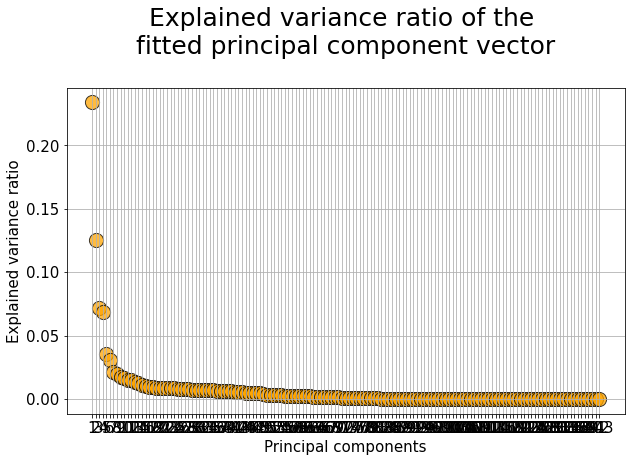

In [74]:
# plot the explained variance ratio for each principal component
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_50_scaled_pca.explained_variance_ratio_))],
            y=df_50_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_50_scaled_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [75]:
# transform the scaled data set using the fitted PCA object
X_train_50_scaled_trans = pca_50.transform(df_50_scaled)

In [76]:
# put it in a data frame
X_train_50_scaled_trans = pd.DataFrame(data=X_train_50_scaled_trans)

In [77]:
# assign the most meaningful variables
variables_50 = [0,1,2,3,4,5,6]

#### 2.4 Logistic Regression (PCA)

In [78]:
# create a Logistic Regression Model / fit the model (PCA data)
logreg_50_pca = LogisticRegression()
logreg_50_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

LogisticRegression()

In [79]:
# scale test data with standard scaler / transform the scaled data set using the fitted PCA object
X_test_50_scaled = scaler.transform(X_test_50)
X_test_50_scaled_trans = pca_50.transform(X_test_50_scaled)

In [80]:
# put it in a data frame
X_test_50_scaled_trans = pd.DataFrame(data=X_test_50_scaled_trans)

In [81]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_50_pca = logreg_50_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])
predicted = y_pred_logreg_50_pca.tolist()

In [82]:
# print the classification report
print(classification_report(y_test_50, y_pred_logreg_50_pca))

              precision    recall  f1-score   support

          1X       0.40      0.03      0.06       416
           2       0.62      0.97      0.76       686

    accuracy                           0.62      1102
   macro avg       0.51      0.50      0.41      1102
weighted avg       0.54      0.62      0.50      1102



In [83]:
# print the result of the profit metric
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-2.57 units in 1102 games
-0.23 % gain per game


#### 2.5 Support Vector Machine (PCA)

In [84]:
# create a SVM-Model
model_50_svm_pca = SVC(kernel='linear', verbose = 1)

In [85]:
# fit the model
model_50_svm_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

[LibSVM]

SVC(kernel='linear', verbose=1)

In [86]:
# predict the test data
y_pred_50_svm_pca = model_50_svm_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

In [87]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_svm_pca))

              precision    recall  f1-score   support

          1X       0.00      0.00      0.00       416
           2       0.62      1.00      0.77       686

    accuracy                           0.62      1102
   macro avg       0.31      0.50      0.38      1102
weighted avg       0.39      0.62      0.48      1102



In [88]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_svm_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-0.58 units in 1102 games
-0.05 % gain per game


#### 2.6 Random Forest (PCA)

In [89]:
# create a Random Forest-Model
model_50_rf = RandomForestClassifier(n_estimators=120, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

In [90]:
# fit the model
model_50_rf.fit(X_train_50_scaled_trans[variables_50], y_train_50)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished


RandomForestClassifier(max_features='sqrt', n_estimators=120, n_jobs=-1,
                       random_state=42, verbose=1)

In [91]:
# predict the test data
y_pred_50_rf = model_50_rf.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.0s finished


In [92]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_rf))

              precision    recall  f1-score   support

          1X       0.42      0.24      0.30       416
           2       0.63      0.80      0.71       686

    accuracy                           0.59      1102
   macro avg       0.53      0.52      0.51      1102
weighted avg       0.55      0.59      0.56      1102



In [93]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_rf
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-6.37 units in 1102 games
-0.58 % gain per game


#### 2.7 Extra Trees (PCA)

In [94]:
# create a Extra Trees-Model
model_50_extra_pca = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [95]:
# fit the model
model_50_extra_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

ExtraTreesClassifier(random_state=42)

In [96]:
# predict the test data
y_pred_50_extra_pca = model_50_extra_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

In [97]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_extra_pca))

              precision    recall  f1-score   support

          1X       0.39      0.19      0.26       416
           2       0.63      0.82      0.71       686

    accuracy                           0.58      1102
   macro avg       0.51      0.51      0.48      1102
weighted avg       0.54      0.58      0.54      1102



In [98]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_extra_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-10.85 units in 1102 games
-0.98 % gain per game


#### 2.8 KNN (PCA)

In [99]:
# create a KNN-Model
model_50_knn_pca = KNeighborsClassifier(n_neighbors=5, metric='minkowski', n_jobs=-1)

In [100]:
# fit the model
model_50_knn_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

KNeighborsClassifier(n_jobs=-1)

In [101]:
# predict the test data
y_pred_50_knn_pca = model_50_knn_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

In [102]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_knn_pca))

              precision    recall  f1-score   support

          1X       0.40      0.35      0.37       416
           2       0.64      0.69      0.66       686

    accuracy                           0.56      1102
   macro avg       0.52      0.52      0.52      1102
weighted avg       0.55      0.56      0.55      1102



In [103]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_knn_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-6.58 units in 1102 games
-0.6 % gain per game


#### 2.9 AdaBoost (PCA)

In [104]:
# create a AdaBoost-Model
model_50_ada_pca = AdaBoostClassifier()

In [105]:
# fit the model
model_50_ada_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

AdaBoostClassifier()

In [106]:
# predict the test data
y_pred_50_ada_pca = model_50_ada_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

In [107]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_ada_pca))

              precision    recall  f1-score   support

          1X       0.39      0.17      0.23       416
           2       0.62      0.84      0.72       686

    accuracy                           0.59      1102
   macro avg       0.51      0.50      0.48      1102
weighted avg       0.54      0.59      0.53      1102



In [108]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_ada_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-9.59 units in 1102 games
-0.87 % gain per game


#### 2.10 XGBoost (PCA)

In [109]:
# create a XGBoost-Model
model_50_xgb_pca = xgb.XGBClassifier()

In [110]:
# fit the model
model_50_xgb_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

[12:04:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [111]:
# predict the test data
y_pred_50_xgb_pca = model_50_xgb_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

In [112]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_xgb_pca))

              precision    recall  f1-score   support

          1X       0.40      0.29      0.34       416
           2       0.63      0.73      0.68       686

    accuracy                           0.57      1102
   macro avg       0.51      0.51      0.51      1102
weighted avg       0.54      0.57      0.55      1102



In [113]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_xgb_pca
profit_metric(actual, predicted, away_odd, dc_odd, avg_odd_fav, avg_odd_out)

-8.68 units in 1102 games
-0.79 % gain per game


## 3 Favorite Dataframe

In [114]:
# loading the dataframe
X_train_fav = pd.read_csv('Data/model_away_csv/X_train_away_fav.csv')
X_test_fav = pd.read_csv('Data/model_away_csv/X_test_away_fav.csv')
y_train_fav = pd.read_csv('Data/model_away_csv/y_train_away_fav.csv')
y_test_fav = pd.read_csv('Data/model_away_csv/y_test_away_fav.csv')
y_train_fav = y_train_fav['two_way_a_odd']
y_test_fav = y_test_fav['two_way_a_odd']

In [115]:
# assigning the variables of the profit metric
actual = y_test_fav
home_odd = X_test_fav.MaxAway
dc_odd = X_test_fav.dc_home

#### 3.1 Dummy-Classifier

In [116]:
# create a Dummy-Model
model_dummy_fav = DummyClassifier(strategy = 'most_frequent')

In [117]:
# fit the model
model_dummy_fav.fit(X_train_fav, y_train_fav)

DummyClassifier(strategy='most_frequent')

In [118]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_dummy_fav = model_dummy_fav.predict(X_test_fav)
predicted = y_pred_dummy_fav.tolist()

In [119]:
# print the classification report
print(classification_report(y_test_fav, y_pred_dummy_fav))

              precision    recall  f1-score   support

          1X       0.00      0.00      0.00        75
           2       0.67      1.00      0.81       155

    accuracy                           0.67       230
   macro avg       0.34      0.50      0.40       230
weighted avg       0.45      0.67      0.54       230



In [120]:
# print the result of the profit metric
profit_metric_fav(actual, predicted, away_odd, dc_odd)

18.73 units in 230 games
8.14 % gain per game


#### 3.2 Logistic Regression

In [121]:
# create a Logistic Regression Model
logreg_fav = LogisticRegression()

In [122]:
# fit the model
logreg_fav.fit(X_train_fav, y_train_fav)

LogisticRegression()

In [123]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_fav = logreg_fav.predict(X_test_fav)
predicted = y_pred_logreg_fav.tolist()

In [124]:
# print the classification report
print(classification_report(y_test_fav, y_pred_logreg_fav))

              precision    recall  f1-score   support

          1X       0.48      0.20      0.28        75
           2       0.70      0.90      0.79       155

    accuracy                           0.67       230
   macro avg       0.59      0.55      0.53       230
weighted avg       0.63      0.67      0.62       230



In [125]:
# print the result of the profit metric
profit_metric_fav(actual, predicted, away_odd, dc_odd)

21.37 units in 230 games
9.29 % gain per game


#### 3.3 Dimensionality Reduction

##### Data scaling
PCA requires scaling/normalization of the data to work properly.

In [126]:
# scale train data with standard scaler
X_train_fav_scaled = scaler.fit_transform(X_train_fav)
df_fav_scaled = pd.DataFrame(data=X_train_fav_scaled,columns=X_train_fav.columns)

##### Principal Component Analysis

In [127]:
# create a PCA object
pca_fav = PCA(n_components=None)

In [128]:
# fit the PCA object
df_fav_scaled_pca = pca_fav.fit(df_fav_scaled)

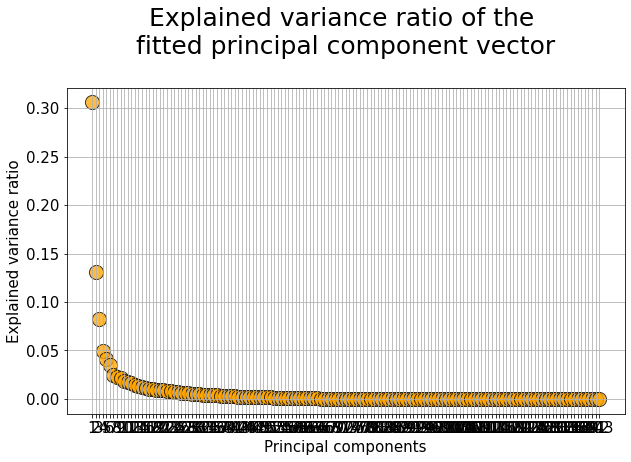

In [129]:
# plot the explained variance ratio for each principal component
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_fav_scaled_pca.explained_variance_ratio_))],
            y=df_fav_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_fav_scaled_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [130]:
# transform the scaled data set using the fitted PCA object
X_train_fav_scaled_trans = pca_fav.transform(df_fav_scaled)

In [131]:
# put it in a data frame
X_train_fav_scaled_trans = pd.DataFrame(data=X_train_fav_scaled_trans)

In [132]:
# assign the most meaningful variables
variables_fav = [0,1,2,3,4,5,6]

#### 3.4 Logistic Regression (PCA)

In [133]:
# create a Logistic Regression Model / fit the model (PCA data)
logreg_fav_pca = LogisticRegression()
logreg_fav_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

LogisticRegression()

In [134]:
# scale test data with standard scaler / transform the scaled data set using the fitted PCA object
X_test_fav_scaled = scaler.transform(X_test_fav)
X_test_fav_scaled_trans = pca_fav.transform(X_test_fav_scaled)

In [135]:
# put it in a data frame
X_test_fav_scaled_trans = pd.DataFrame(data=X_test_fav_scaled_trans)

In [136]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_fav_pca = logreg_fav_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])
predicted = y_pred_logreg_fav_pca.tolist()

In [137]:
# print the classification report
print(classification_report(y_test_fav, y_pred_logreg_fav_pca))

              precision    recall  f1-score   support

          1X       0.45      0.12      0.19        75
           2       0.69      0.93      0.79       155

    accuracy                           0.67       230
   macro avg       0.57      0.52      0.49       230
weighted avg       0.61      0.67      0.59       230



In [138]:
# print the result of the profit metric
profit_metric_fav(actual, predicted, away_odd, dc_odd)

16.35 units in 230 games
7.11 % gain per game


#### 3.5 Support Vector Machine (PCA)

In [139]:
# create a SVM-Model
model_fav_svm_pca = SVC(kernel='linear', verbose = 1)

In [140]:
# fit the model
model_fav_svm_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

[LibSVM]

SVC(kernel='linear', verbose=1)

In [141]:
# predict the test data
y_pred_fav_svm_pca = model_fav_svm_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

In [142]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_svm_pca))

              precision    recall  f1-score   support

          1X       0.00      0.00      0.00        75
           2       0.67      1.00      0.81       155

    accuracy                           0.67       230
   macro avg       0.34      0.50      0.40       230
weighted avg       0.45      0.67      0.54       230



In [143]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_svm_pca
profit_metric_fav(actual, predicted, away_odd, dc_odd)

18.73 units in 230 games
8.14 % gain per game


#### 3.6 Random Forest (PCA)

In [144]:
# create a Random Forest-Model
model_fav_rf = RandomForestClassifier(n_estimators=120, 
                                      random_state=42, 
                                      max_features = 'sqrt',
                                      n_jobs=-1, verbose = 1)

In [145]:
# fit the model
model_fav_rf.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished


RandomForestClassifier(max_features='sqrt', n_estimators=120, n_jobs=-1,
                       random_state=42, verbose=1)

In [146]:
# predict the test data
y_pred_fav_rf = model_fav_rf.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.0s finished


In [147]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_rf))

              precision    recall  f1-score   support

          1X       0.28      0.12      0.17        75
           2       0.67      0.85      0.75       155

    accuracy                           0.61       230
   macro avg       0.47      0.49      0.46       230
weighted avg       0.54      0.61      0.56       230



In [148]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_rf
profit_metric_fav(actual, predicted, away_odd, dc_odd)

11.68 units in 230 games
5.08 % gain per game


#### 3.7 Extra Trees (PCA)

In [149]:
# create a Extra Trees-Model
model_fav_extra_pca = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [150]:
# fit the model
model_fav_extra_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

ExtraTreesClassifier(random_state=42)

In [151]:
# predict the test data
y_pred_fav_extra_pca = model_fav_extra_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

In [152]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_extra_pca))

              precision    recall  f1-score   support

          1X       0.25      0.12      0.16        75
           2       0.66      0.83      0.73       155

    accuracy                           0.60       230
   macro avg       0.45      0.47      0.45       230
weighted avg       0.53      0.60      0.55       230



In [153]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_extra_pca
profit_metric_fav(actual, predicted, away_odd, dc_odd)

7.99 units in 230 games
3.48 % gain per game


#### 3.8 KNN (PCA)

In [154]:
# create a KNN-Model
model_fav_knn_pca = KNeighborsClassifier(n_neighbors=5, metric='minkowski', n_jobs=-1)

In [155]:
# fit the model
model_fav_knn_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

KNeighborsClassifier(n_jobs=-1)

In [156]:
# predict the test data
y_pred_fav_knn_pca = model_fav_knn_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

In [157]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_knn_pca))

              precision    recall  f1-score   support

          1X       0.38      0.23      0.28        75
           2       0.69      0.82      0.75       155

    accuracy                           0.63       230
   macro avg       0.53      0.52      0.52       230
weighted avg       0.59      0.63      0.60       230



In [158]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_knn_pca
profit_metric_fav(actual, predicted, away_odd, dc_odd)

15.46 units in 230 games
6.72 % gain per game


#### 3.9 AdaBoost (PCA)

In [159]:
# create a AdaBoost-Model
model_fav_ada_pca = AdaBoostClassifier()

In [160]:
# fit the model
model_fav_ada_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

AdaBoostClassifier()

In [161]:
# predict the test data
y_pred_fav_ada_pca = model_fav_ada_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

In [162]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_ada_pca))

              precision    recall  f1-score   support

          1X       0.27      0.17      0.21        75
           2       0.66      0.77      0.71       155

    accuracy                           0.57       230
   macro avg       0.46      0.47      0.46       230
weighted avg       0.53      0.57      0.55       230



In [163]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_ada_pca
profit_metric_fav(actual, predicted, away_odd, dc_odd)

4.43 units in 230 games
1.93 % gain per game


#### 3.10 XGBoost (PCA)

In [164]:
# create a XGBoost-Model
model_fav_xgb_pca = xgb.XGBClassifier()

In [165]:
# fit the model
model_fav_xgb_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

[12:04:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [166]:
# predict the test data
y_pred_fav_xgb_pca = model_fav_xgb_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

In [167]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_xgb_pca))

              precision    recall  f1-score   support

          1X       0.30      0.17      0.22        75
           2       0.67      0.81      0.73       155

    accuracy                           0.60       230
   macro avg       0.49      0.49      0.48       230
weighted avg       0.55      0.60      0.56       230



In [168]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_xgb_pca
profit_metric_fav(actual, predicted, away_odd, dc_odd)

10.31 units in 230 games
4.48 % gain per game
